In [1]:
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from mlxtend.plotting import plot_decision_regions

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor


from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from imblearn.pipeline import make_pipeline  as imb_make_pipeline
from sklearn.pipeline import make_pipeline
from imblearn import FunctionSampler

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

from sklearn.metrics import classification_report, f1_score, auc, accuracy_score
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve

from prettytable import PrettyTable
from collections import Counter

%matplotlib inline
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings("ignore")

random_state = 42

In [2]:
df = pd.read_csv('../data/default-of-credit-card-clients.csv')
df = df.rename(columns={"PAY_0": "PAY_1"}, errors="raise")
df.drop(columns=['ID'],inplace=True)

## Feature Engineering

In [4]:
round(abs(df.corr()['default payment next month']),2).sort_values(ascending=False)

# get the first seven rows

default payment next month    1.00
PAY_1                         0.32
PAY_2                         0.26
PAY_3                         0.24
PAY_4                         0.22
PAY_5                         0.20
PAY_6                         0.19
LIMIT_BAL                     0.15
PAY_AMT1                      0.07
PAY_AMT2                      0.06
PAY_AMT3                      0.06
PAY_AMT4                      0.06
PAY_AMT5                      0.06
PAY_AMT6                      0.05
SEX                           0.04
EDUCATION                     0.03
MARRIAGE                      0.02
BILL_AMT1                     0.02
AGE                           0.01
BILL_AMT3                     0.01
BILL_AMT4                     0.01
BILL_AMT5                     0.01
BILL_AMT6                     0.01
BILL_AMT2                     0.01
Name: default payment next month, dtype: float64

In [3]:
low_corr_cols = pd.Series(round(abs(df.corr()['default payment next month']),2).sort_values(ascending=False)[8:].index)
low_corr_cols.values

array(['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
       'PAY_AMT6', 'SEX', 'EDUCATION', 'MARRIAGE', 'BILL_AMT1', 'AGE',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'BILL_AMT2'],
      dtype=object)

## Utils

In [4]:
def drop_correlated_data(df):    
    # remove the values that have a lower correlation in absolute value
    low_corr_cols = pd.Series(round(abs(df.corr()['default payment next month']),2).sort_values(ascending=False)[8:].index)
    df = df.drop(columns=low_corr_cols)
    
    y, X = df["default payment next month"], df.drop("default payment next month", axis=1)
    
    return X,y

def split_data(X,y, random_state=42):
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25,
                                                        stratify= y, random_state=random_state)

    return X_train, X_test, y_train, y_test

def report(y_true, y_pred, title = "", 
           params = None, show_cm = True, show_params = True):

    nl = '\n'
    sp = "*"*len(title)
    
#     print("__"*30 + nl)
    if title:
        title = "Classification report for " + title + " on yet-unseen data"
        sp = "*"*len(title)
        print(sp + nl + title + nl + sp +nl)
    
    acc = accuracy_score(y_true, y_pred)
    f_score = f1_score(y_true, y_pred)
    print("Accuracy: {:.3f}".format(acc))
    print("f-score: {:.3f}".format(f_score))
    
    if params and show_params:
        new_params = {}
        for k in params:
            new_params[k.split("__")[-1]] = params[k]
            
        print("\nBest Parameters:")
#         pprint(new_params, indent = 4)
        print(grid_search.best_estimator_)
        
#     print(classification_report(y_true, y_pred))
    if show_cm:
        plt.figure(figsize = (6,5))
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot = True, 
                    cmap = 'YlGnBu', 
                    annot_kws={"size": 18},
                    linecolor = 'w',
                    linewidth = 4
                   )
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted labels")
        plt.ylabel("True labels")
    
    return (acc, f_score)
    
scores_dict = {}
gs_trained_models =  {}

def outliers_iqr(X,y):
    
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)

    IQR = Q3 - Q1
    
    df_out = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
    
    y = df_out["default payment next month"]
    X = df_out.drop(columns=["default payment next month"])
    
    return X, y

def outliers_lof(X,y, n_neighbors=20):
    
    y = np.asarray(y)
    X = np.asarray(X)

    outliers = LocalOutlierFactor(n_neighbors = n_neighbors, n_jobs = -1).fit_predict(X)
    X = X[outliers == 1, :]
    y = y[outliers == 1]

    return X, y

In [7]:
y, X = df["default payment next month"], df.drop("default payment next month", axis=1)
X_2, y_2 = outliers_iqr(X,y)
X_3, y_3 = outliers_lof(X,y)

In [8]:
Counter(y), Counter(y_2), Counter(y_3)

(Counter({1: 6636, 0: 23364}),
 Counter({0: 10993}),
 Counter({1: 5282, 0: 18174}))

In [9]:
X_2.shape, X_3.shape

((10993, 23), (23456, 23))

In [5]:
random_state = 42

scaler = StandardScaler()

pca = PCA(n_components=11, random_state=random_state)

under_s = RandomUnderSampler(sampling_strategy=0.8, random_state=random_state)
over_s = SMOTE(sampling_strategy='minority', random_state=random_state)
smoteenn = SMOTEENN(random_state=random_state)

cases = []

param_grids = {
    "rf" : {
        "randomforestclassifier__n_estimators":[80,100,120],
        "randomforestclassifier__criterion":["gini", "entropy"],
        "randomforestclassifier__max_features":['sqrt','log2'],
        "randomforestclassifier__n_jobs": [-1],
    },
    "svc" : {
        "svc__kernel": ['linear', 'rbf', 'poly'],
        "svc__gamma" :['scale', 'auto'],
        "svc__C": [0.8, 1.0,1.2] 
    },
    "knn" : {
        "kneighborsclassifier__n_neighbors": [10, 50, 75],
        "kneighborsclassifier__weights": ["uniform", "distance"],
        "kneighborsclassifier__algorithm": ["auto", "ball_tree", "kd_tree"],
        "kneighborsclassifier__n_jobs": [-1],
    },
    "logisticregression" : {
        "logisticregression__penalty": ['l1','l2'],
        "logisticregression__tol": [1e-1, 1e-2, 1e-3, 1e-4],
        "logisticregression__C": [0.6,0.8, 1.0,1.2, 1.4],
        "logisticregression__solver" : ['saga'],
        "logisticregression__max_iter" : [500]
    }
}

models = {
    "rf" : RandomForestClassifier(random_state=random_state),
    "knn" : KNeighborsClassifier(n_neighbors=9),
    "svc" : SVC(),
    "logistic": LogisticRegression(random_state=random_state)
} 

In [15]:
def training_pipeline(df, tests, model, param_grid, random_state=42):
    
    y, X = df["default payment next month"], df.drop("default payment next month", axis=1)
    
    results = []
    counter = 1
    
    for curr_test in tests:
        
        outliers_option, scaling, pca, resampling = curr_test
    
        field_0 = ''

        if outliers_option:

            if outliers_option == "iqr":
                # update
                X, y = outliers_iqr(df)
                field_0 += 'IQR + '

            if outliers_option == "lof":
                X, y = outliers_lof(X,y)
                field_0 += 'LOF + '


        # both imb_make_pipeline and make_pipeline have some problems 
        # with giving an array as input. So I manually check for each combinations
        if pca and resampling and scaling:
            field_0 += f'Scaling + PCA + {str(resampling).split("(")[0]}'
            pipeline = imb_make_pipeline(scaler,pca,resampling,model)

        elif not pca and resampling and scaling:
            field_0 += f'Scaling + {str(resampling).split("(")[0]}'
            pipeline = imb_make_pipeline(scaler,resampling,model)

        elif pca and not resampling and scaling:
            field_0 += f'Scaling + PCA'
            pipeline = make_pipeline(scaler,pca,model)

        elif not pca and not resampling and scaling:
            field_0 += f'Scaling'
            pipeline = make_pipeline(scaler,model)
        elif not pca and not resampling and not scaling:
            pipeline = make_pipeline(model)

        X_train, X_test, y_train, y_test = split_data(X, y, 42)

        gridsearch = GridSearchCV(pipeline, param_grid, scoring='f1', n_jobs=-1)
        gridsearch.fit(X_train, y_train)

        best_estimator = gridsearch.best_estimator_

        y_pred = best_estimator.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        curr_result = (field_0, f1, gridsearch.best_params_)

        results.append(curr_result)
        
        print(f"Done {counter}/{len(tests)}")
        counter += 1
        
    return results, y_pred, y_test

def plot_summary(result,y_pred, y_test):
    
    fig = plt.figure(constrained_layout=False,figsize=(14,4))
    gs1 = fig.add_gridspec(nrows=1, ncols=6, left=0.1, right=0.90, wspace=0.5, hspace=0.5)
    ax1 = fig.add_subplot(gs1[0,0:3])
    ax2 = fig.add_subplot(gs1[0,3:5])
    
    
    plot_x = []
    plot_y = []
    
    for r in result:
        plot_x.append(r[1])
        plot_y.append(r[0])

    temp_df = pd.DataFrame({'x':plot_x, 'y' :plot_y}).sort_values(['x'], ascending=False)
    
    sns.barplot(x='x',y='y',data=temp_df, palette='viridis',ax=ax1)
    ax1.set_xlabel("F1-score", fontsize="14")
    ax1.set_ylabel("")
    ax1.set_yticklabels(temp_df.y,fontsize=13)
    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot = True, 
                cmap = 'viridis', 
                annot_kws={"size": 14},
                linecolor = 'w',
                linewidth = 4,ax=ax2,
                fmt='d'
               )
    
    ax2.set_xlabel("Predicted labels",fontsize="14")
    ax2.set_ylabel("True labels",fontsize="14")
    return plt

# Random Forest

In [ ]:
# outliers_option, scaling, pca, resampling = curr_test
# SET ALL COMBINATIONS

pca_options = [None, pca]
scaling = [True]
outliers_options = [None, "lof"]
resampling_options = [None, under_s, over_s, smoteenn]

tests = []

for o in outliers_options:
    for s in scaling:
        for p in pca_options:
            for r in resampling_options:
                tests.append([o,s,p,r])

# outliers_option, scaling, pca, resampling = curr_test
results_rf, y_pred_rf, y_test_rf = training_pipeline(df, tests, models["rf"], param_grids["rf"])

Done 1/16
Done 2/16
Done 3/16
Done 4/16
Done 5/16
Done 6/16
Done 7/16


In [ ]:
sns.set_style('darkgrid')
plt_rf = plot_summary(results_rf,y_pred_rf, y_test_rf)
plt_rf.savefig('../images/18-rf_results.svg')
plt_rf.show()

In [76]:
# outliers_option, scaling, pca, resampling = curr_test
# SET ALL COMBINATIONS

pca_options = [None]
scaling = [True]
outliers_options = ["lof"]
resampling_options = [None, under_s, over_s, smoteenn]

tests = []

for o in outliers_options:
    for s in scaling:
        for p in pca_options:
            for r in resampling_options:
                tests.append([o,s,p,r])

# outliers_option, scaling, pca, resampling = curr_test
results_rf, y_pred_rf, y_test_rf = training_pipeline(df, tests, models["rf"], param_grids["rf"])

KeyboardInterrupt: 

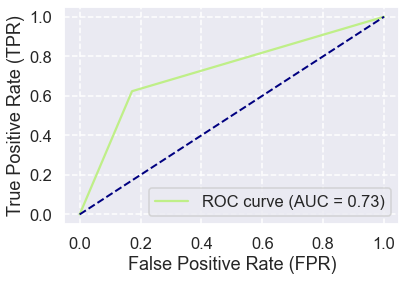

In [44]:
sns.set('talk', 'darkgrid',
        rc={'grid.linestyle': '--'})

fpr, tpr, _ = roc_curve(y_test_rf,y_pred_rf)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='#bfef88',label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')

plt.legend(loc="lower right")
plt.show()


# KNN

In [1]:
results_knn, best_estimator_knn = training_pipeline(df, tests, models["knn"], param_grids["knn"])

NameError: name 'training_pipeline' is not defined

[('Scaling + PCA',
  0.6857291395892904,
  {'kneighborsclassifier__algorithm': 'auto',
   'kneighborsclassifier__n_jobs': -1,
   'kneighborsclassifier__n_neighbors': 50,
   'kneighborsclassifier__weights': 'distance'}),
 ('Scaling + PCA + RandomUnderSampler',
  0.6470710860954764,
  {'kneighborsclassifier__algorithm': 'auto',
   'kneighborsclassifier__n_jobs': -1,
   'kneighborsclassifier__n_neighbors': 75,
   'kneighborsclassifier__weights': 'distance'}),
 ('Scaling + PCA + SMOTE',
  0.6447608616283316,
  {'kneighborsclassifier__algorithm': 'auto',
   'kneighborsclassifier__n_jobs': -1,
   'kneighborsclassifier__n_neighbors': 75,
   'kneighborsclassifier__weights': 'distance'}),
 ('Scaling + PCA + SMOTEENN',
  0.515017793594306,
  {'kneighborsclassifier__algorithm': 'auto',
   'kneighborsclassifier__n_jobs': -1,
   'kneighborsclassifier__n_neighbors': 75,
   'kneighborsclassifier__weights': 'distance'}),
 ('LOF + Scaling + PCA',
  0.6945397815912636,
  {'kneighborsclassifier__algorithm': 'auto',
   'kneighborsclassifier__n_jobs': -1,
   'kneighborsclassifier__n_neighbors': 75,
   'kneighborsclassifier__weights': 'distance'}),
 ('LOF + Scaling + PCA + RandomUnderSampler',
  0.6718003186404674,
  {'kneighborsclassifier__algorithm': 'auto',
   'kneighborsclassifier__n_jobs': -1,
   'kneighborsclassifier__n_neighbors': 75,
   'kneighborsclassifier__weights': 'distance'}),
 ('LOF + Scaling + PCA + SMOTE',
  0.6857142857142856,
  {'kneighborsclassifier__algorithm': 'auto',
   'kneighborsclassifier__n_jobs': -1,
   'kneighborsclassifier__n_neighbors': 75,
   'kneighborsclassifier__weights': 'distance'}),
 ('LOF + Scaling + PCA + SMOTEENN',
  0.5528885272579334,
  {'kneighborsclassifier__algorithm': 'auto',
   'kneighborsclassifier__n_jobs': -1,
   'kneighborsclassifier__n_neighbors': 50,
   'kneighborsclassifier__weights': 'distance'})]

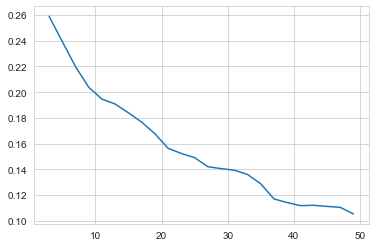

In [65]:
# choose the value of K

k_list = [i for i in range(3,50,2)]
f1_list = []

y, X = df["default payment next month"], df.drop("default payment next month", axis=1)
X_train, X_test, y_train, y_test = split_data(X, y, 42)

for k in k_list:
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test)
    f1_list.append(f1_score(y_test,y_pred))
    

plt.plot(k_list,f1_list)    

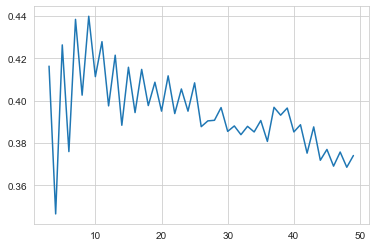

In [64]:
# choose the value of K

k_list = [i for i in range(3,50)]
f1_list = []

X_filt, y_filt = drop_correlated_data(df)
X_train, X_test, y_train, y_test = split_data(X_filt, y_filt, 42)

for k in k_list:
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test)
    f1_list.append(f1_score(y_test,y_pred))
    

plt.plot(k_list,f1_list)    

## Logistic Regression

In [9]:
pca_options = [None, pca]
scaling = [True]
outliers_options = [None, "lof"]
resampling_options = [None, under_s, over_s, smoteenn]

tests = []

for o in outliers_options:
    for s in scaling:
        for p in pca_options:
            for r in resampling_options:
                tests.append([o,s,p,r])

In [10]:
results_log, y_pred_log, y_test_log = training_pipeline(df, tests, models["logistic"], param_grids["logisticregression"])

Done 1/16
Done 2/16
Done 3/16
Done 4/16
Done 5/16
Done 6/16
Done 7/16
Done 8/16
Done 9/16
Done 10/16
Done 11/16
Done 12/16
Done 13/16
Done 14/16
Done 15/16
Done 16/16


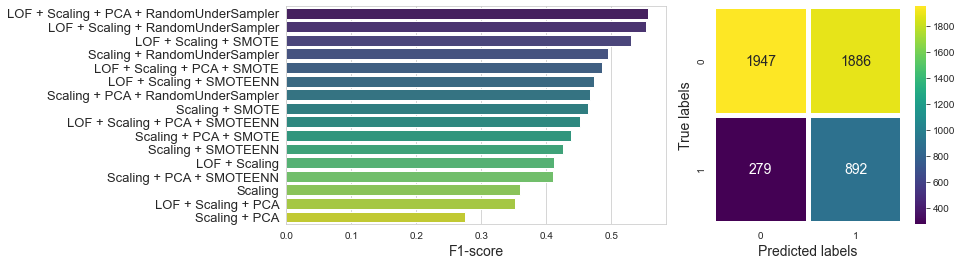

In [16]:
sns.set_style('whitegrid')
plt_lr = plot_summary(results_log,y_pred_log, y_test_log)
plt_lr.savefig('../images/21-lr_results.svg')
plt_lr.show()

In [45]:
results_log

('LOF + Scaling + PCA + RandomUnderSampler',
  0.5561632309633993,
  {'logisticregression__C': 0.6,
   'logisticregression__max_iter': 500,
   'logisticregression__penalty': 'l1',
   'logisticregression__solver': 'saga',
   'logisticregression__tol': 0.01}),

[('Scaling',
  0.3590664272890485,
  {'logisticregression__C': 1.4,
   'logisticregression__max_iter': 500,
   'logisticregression__penalty': 'l1',
   'logisticregression__solver': 'saga',
   'logisticregression__tol': 0.0001}),
 ('Scaling + RandomUnderSampler',
  0.4955189361087019,
  {'logisticregression__C': 1.2,
   'logisticregression__max_iter': 500,
   'logisticregression__penalty': 'l1',
   'logisticregression__solver': 'saga',
   'logisticregression__tol': 0.001}),
 ('Scaling + SMOTE',
  0.46354733405875953,
  {'logisticregression__C': 1.4,
   'logisticregression__max_iter': 500,
   'logisticregression__penalty': 'l1',
   'logisticregression__solver': 'saga',
   'logisticregression__tol': 0.1}),
 ('Scaling + SMOTEENN',
  0.42649820727334814,
  {'logisticregression__C': 0.6,
   'logisticregression__max_iter': 500,
   'logisticregression__penalty': 'l2',
   'logisticregression__solver': 'saga',
   'logisticregression__tol': 0.001}),
 ('Scaling + PCA',
  0.2743022136669875,
  {'lo